# Parallel K-Means Clustering Algorithm on Spark

Author: **Giorgio Polla**  
Date: **21/11/2019**  

Implementation of the K-Means clustering algorithm on Spark, with Python.  
The algorithm is tested using the famous Iris dataset (available on Kaggle at https://www.kaggle.com/uciml/iris), and against Sklearn's implementation of K-Means.


### Libraries and constants

Import of the following libraries:  
* `time` to track the time performance of the implementation;  
* `pyspark` to utilize *Spark*;  
* `pandas` to manipulate dataframes for the sklearn comparison;
* `numpy` to easily operate with number arrays;  
* `matplotlib` to plot graphs;  
* `sklearn` for preprocessing and for comparing the results obtained;  
* `scipy` to add interpolation to plotted graphs.  

Moreover, some operative constants used in the following are defined, regarding input and output paths and formats, and the maximum number of workers and partitions utilised by _Spark_.

In [1]:
import time
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.interpolate import make_interp_spline

FILE_PATH = '../data/iris'
OUT_PATH = '../out/'
IMG_FORMAT = 'png'
N_WORKERS = 8
N_PARTITIONS = 8

### File reading
The dataset is loaded as an RDD, using the `textFile()` function.  
The RDD is then manipulated in order to have each record divided in a features array ( gathered in **rdd_x**), and a label (grouped in **rdd_y)**.

In [2]:
def read_file(file_path):
    rdd = sc.textFile(file_path, N_PARTITIONS)
    
    rdd = rdd.map(
        lambda x:
            x.split()
    )
    
    rdd_x = rdd.map(
        lambda x: 
            np.array([float(el) for el in x[:-1]])
    )
    
    rdd_y = rdd.map(
        lambda x:           
            x[-1]
    )
    return rdd_x, rdd_y

### Standardisation
Each row of the RDD is standardised; this is done by first obtaining the mean for each column, then obtaining the standard deviation for them, and finally applying the standardisation formula.  

In [3]:
def standardise(rdd):    
    n_rows = rdd.count()
    
    col_sum = rdd.reduce(
        lambda x, y:
            [sum(el) for el in zip(x, y)]
    )
    mean = np.divide(col_sum, n_rows)
    
    variance = rdd.map(
        lambda x: np.square(x - mean)
    ).reduce(
        lambda x, y:
            [sum(el) for el in zip(x, y)]
    )
    std_dev = np.sqrt(np.divide(variance, n_rows))
    
    rdd = rdd.map(
        lambda x:
            np.divide((x - mean), std_dev)
    )
    
    return rdd

### Clustering process
The clustering follows the typical K-Means fashion, with some adjustments to exploit the Spark parallelisation.  
It is worth noting that the notation is consistent, and in particular:  
* **rdd** is an RDD containing the records on operate the clustering;
* **k** is the number of cluster setted to identify;  
* **c** is a centroid (float array);  
* **x** is the feature array of one data point (float array);  
* **centroids** is the array of centroids (array of **c**);  

In the first section there are the support functions for the proper clustering phase.  
* `init_rdd()` intialises the rdd, assigning every record to the fake cluster *-1*;  
* `init_centroids()` calculates and returns the intialised centroid array of **c**, either extracting random records from the rdd, or exctracting the first **k** records, depending on the user preferences;  
* `calc_distance()` calculates the distance between a centroid **c** and a data point which features are in **x**; now only the *'euclidean'* distance is implemented;  
* `assign_cluster()` calculates the appropriate cluster for a data point which features are in **x**, according to its distance to the current **centroids**;  
* `refine_clusters()` assigns every element of an **rdd** to a specific cluster, according to the current **centroids**;  
* `calculate_centroids()` calculates the position of the new centroids, by taking the mean position of all the elements in the **rdd** belonging to a specific cluser.  
* `cluster_variance()` calculates the cumulative distance of every data point in the **rdd** with respect to the centroid of the cluster it belongs to.  

**Note**: the distance selection, due to the many steps required until the reaching of the actual `calc_distance()` function, is passed as an additional argument in the previous functions.

In [4]:
def init_rdd(rdd):
    rdd = rdd.map(
        lambda x: (
            -1,
            x
        )
    )
    return rdd


def init_centroids(rdd, k, random=True):
    if random:
        return rdd.takeSample(False, k)
    return rdd.take(k)
    
    
def calc_distance(c, x, dist_type='euclidean'):
    print(dist_type)
    if dist_type == 'euclidean':
        return np.linalg.norm(c - x)
    else:
        raise Exception('Distance Type not recognized.')
        sys.exit()
    
    
def assign_cluster(centroids, x, *args, **kwargs):
    distances = [calc_distance(c, x, dist_type=args[0]) for c in centroids]
    min_index = np.argmin(distances)    
    return min_index


def redefine_clusters(rdd, centroids, *args, **kwargs):
    rdd = rdd.map(
        lambda x: (
            assign_cluster(centroids, x[1], args[0]),
            x[1]
        )
    )
    return rdd

    
def calculate_centroids(rdd):
    centroids = rdd.map(
        lambda x: (
            x[0], (
                x[1],
                1
            )
        )
    ).reduceByKey(
        lambda x, y: (
            x[0] + y[0],
            x[1] + y[1]
        )
    ).map(
        lambda x: [
            x[0],
            x[1][0] / x[1][1]
        ]
    ).collect()
    
    centroids = [el[1] for el in sorted(centroids, key=itemgetter(0))]
    return np.array(centroids)


def cluster_variance(rdd, centroids, *args, **kwargs):
    variance = rdd.map(
        lambda x: 
            calc_distance(centroids[x[0]], x[1], args[0])
    ).reduce(
        lambda x, y:
            x + y
    )
    
    return variance    

The proper clustering process takes the additional parameters:  
* **iterations**, the maximum number of iterations to go though;
* **tolerance**, the minimum cumulative distance the centroids have to move in a single iteration to not interrupt the process;  
* **n_init**, the number of initialisations to repeat;  
* **random_init**, deciding whether to randomly initialise the centroids. If set to *False*, for obvious reasons **n_init** is set to one.
* **distance_metric** between centroids and data points. Right now only *'euclidean'* is implemented;
* **verbose**, influencing the amount of information printed during the process;

The clusteiring phase proceeds inside the main iteration loop by redifing the clusters according the the current centroids, the calculating the new centroids according to the previous clusterisation. If the distance between the new and the old clusters is below the **tolerance** threshold, the process is considered converged and the loop in exited.  

Another external loop manages how many times the whole process is to be repeatd, with different initializations. At each step, the cumulative distance, the predicted array and the centroid position is recorded and at the end only the ones related to the initialisation with less cuulative distance are returned.

In [5]:
def k_means(rdd_x, k, iterations=20, tolerance=0.001, 
            n_init=5, random_init=True, 
            distance_metric='euclidean', verbose=False):
    if k > rdd_x.count():
        print('Invalid K: too big!')
        return
    print('Starting: %d inits\t|\t%d partitions\n' % 
          (n_init, rdd_x.getNumPartitions()))
    init_time = time.time()
    y_arr = []
    cent_arr = []
    variance_arr = []
    
    if random_init == False:
        n_init = 1
    
    for trial in range(n_init):
        start_time = time.time()

        centroids = init_centroids(rdd_x, k, random=random_init)
        rdd = init_rdd(rdd_x)
        n_rows = rdd.count()
        for it in range(iterations):
            rdd = redefine_clusters(rdd, centroids, distance_metric)

            new_centroids = calculate_centroids(rdd)
            
            delta = np.linalg.norm(
                new_centroids - centroids[:len(new_centroids)]
            )
            
            if (delta < tolerance):
                print('%d. Converged.\t|\t' % (trial + 1), end='')
                break
            centroids = new_centroids

            if verbose and it % 5 == 0:
                print('It: %2d\t|\tDelta: %0.4f' % (it, delta))

        y = rdd.map(
            lambda x:
                x[0]
        ).collect()
        
        total_time = time.time() - start_time
        
        y_arr.append(y)
        cent_arr.append(centroids)
        variance_arr.append(cluster_variance(rdd, centroids, distance_metric))
        print('Variance: %0.2f\t|\tTime: %0.2fs' % 
              (variance_arr[-1], total_time)
        )
    
    index = np.argmin(variance_arr)
    y = y_arr[index]
    finish_time = time.time() - init_time
    
    print('\nFinished in %0.2f s.\t|\tChosen init %d.' %
          (finish_time, (index + 1)))
    if verbose:
        [print('Cluster %d: %d' % (n, y.count(n))) \
            for n in sorted(np.unique(y))]
        
    return y, cent_arr[index], finish_time

### Clustering Execution
The following code starts the _Spark_ context with the proper number of workers, reads the file and standardises the records.  

Afteerwards, the clustering algorithm is run.

In [6]:
if 'sc' in locals():
    print('Restart Spark Context')
    sc.stop()
else:
    print('Initialise Spark Context')
sc = pyspark.SparkContext('local[' + str(N_WORKERS) + ']')

rdd_x, rdd_y = read_file(FILE_PATH)
rdd_x = standardise(rdd_x)

Initialise Spark Context


In [7]:
y, ctrd, tot_time = k_means(rdd_x, 3, random_init=True)

Starting: 5 inits	|	8 partitions

1. Converged.	|	Variance: 129.95	|	Time: 3.81s
2. Converged.	|	Variance: 129.89	|	Time: 2.17s
3. Converged.	|	Variance: 147.87	|	Time: 1.38s
4. Converged.	|	Variance: 129.95	|	Time: 1.52s
5. Converged.	|	Variance: 129.62	|	Time: 1.12s

Finished in 10.75 s.	|	Chosen init 5.


### Sklearn K-Means
Here is executed the comparison with the results obtained by the K-Means implementation available in the Sklearn library.
The file is read again, this time using _Pandas_, and the clustering algorithm is applied.  
The results are then plotted in the space composed by the fisrt two features.

0: 48, 1: 50, 2: 52


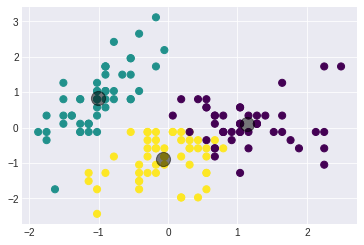

In [29]:
df = pd.read_csv(FILE_PATH + '.csv').iloc[:,:-1]
x = df.values
standard_scaler = preprocessing.StandardScaler()
x = standard_scaler.fit_transform(x)

km = KMeans(n_clusters=3)
km.fit(x)
y_kmeans = km.predict(x)

plt.scatter(x[:, 0], x[:, 1], c=y_kmeans, s=50, cmap='viridis')
ys = list(y_kmeans)
print('0: %2d, 1: %2d, 2: %2d' % (ys.count(0), ys.count(1), ys.count(2)))

centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

Here the results of the Spark K-Means algorithm are plotted, in order to have a meaningful graphical comparison with the results above.

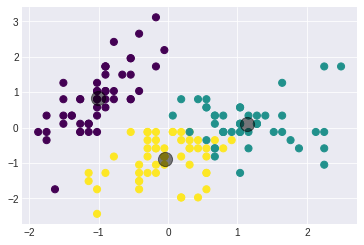

In [31]:
plt.scatter(x[:, 0], x[:, 1], c=y, s=50, cmap='viridis')
plt.scatter(ctrd[:, 0], ctrd[:, 1], c='black', s=200, alpha=0.5);

Finally, the cumulative distance of the Spark and K-Means centroids is calculated and printed.

In [10]:
centr_sklearn = np.array(sorted(centers, key=itemgetter(0)))
centr_this = np.array(sorted(ctrd, key=itemgetter(0)))
                       
print('Total centroid distance error: %0.4f' %
       np.sum(abs(centr_this - centr_sklearn)))

Total centroid distance error: 0.0773


### Performance and Speed Up Curves
The main code below re-runs multiple times the main custering process for a standard of 10 initialisations, recording the time required qith a different number of workers assigned, while maintaining a total of 8 partitions in the **rdd**.

In [11]:
worker_list = list(range(1, N_WORKERS + 1))
time_list = []
n_init = 10

for workers in worker_list:
    if 'sc' in locals():
        sc.stop()
    sc = pyspark.SparkContext('local[' + str(workers) + ']')

    rdd, _ = read_file(FILE_PATH)
    rdd = standardise(rdd)

    _, _, tmp_time = k_means(rdd, 3, n_init=n_init)
    time_list.append(tmp_time)
    print('-----')
print('Ended.')

Starting: 10 inits	|	8 partitions

1. Converged.	|	Variance: 129.89	|	Time: 11.39s
2. Converged.	|	Variance: 129.95	|	Time: 8.67s
3. Converged.	|	Variance: 129.58	|	Time: 7.63s
4. Converged.	|	Variance: 129.62	|	Time: 8.71s
5. Converged.	|	Variance: 149.03	|	Time: 9.61s
6. Converged.	|	Variance: 129.89	|	Time: 11.00s
7. Converged.	|	Variance: 129.89	|	Time: 6.78s
8. Converged.	|	Variance: 149.03	|	Time: 15.39s
9. Converged.	|	Variance: 129.95	|	Time: 8.68s
10. Converged.	|	Variance: 129.95	|	Time: 12.98s

Finished in 106.72 s.	|	Chosen init 3.
-----
Starting: 10 inits	|	8 partitions

1. Converged.	|	Variance: 129.95	|	Time: 4.84s
2. Converged.	|	Variance: 129.62	|	Time: 3.01s
3. Converged.	|	Variance: 129.62	|	Time: 4.27s
4. Converged.	|	Variance: 129.95	|	Time: 5.73s
5. Converged.	|	Variance: 129.67	|	Time: 4.20s
6. Converged.	|	Variance: 129.62	|	Time: 5.26s
7. Converged.	|	Variance: 129.89	|	Time: 4.95s
8. Converged.	|	Variance: 129.89	|	Time: 4.92s
9. Converged.	|	Variance: 129.95	

This functions plots and eventually saves the performance curve, given the array of times required previously obtained. The parameter **interpolate** allows to manage the line interpolation.  

The function is the run.

In [20]:
def performance_curve(time_array, n_init, save=False, interpolate=True):
    t = np.array(time_array.copy())
    x_axis = [x for x in range(1, N_WORKERS + 1)]
    
    if interpolate: 
        spl = make_interp_spline(x_axis, t, k=3)
        x_axis = np.linspace(1, N_WORKERS, 300)
        t = spl(x_axis)

    plt.plot(x_axis, t, linewidth=2)
    plt.gcf().subplots_adjust(bottom=0.1)
    plt.style.use('seaborn-darkgrid')
    plt.title('Performance Curve')
    plt.xlabel('Workers')
    plt.ylabel('Time (s)')
    if save:
        if interpolate:
            name = 'performance_curve_int.'
        else:
            name = 'performance_curve.'
        plt.savefig(OUT_PATH + str(n_init)  + 'it-' + name + IMG_FORMAT)
    plt.show()

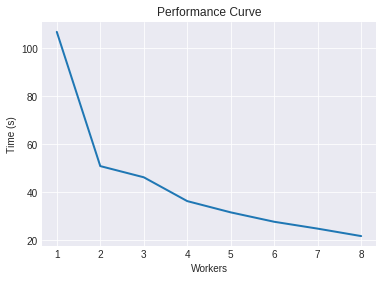

In [27]:
performance_curve(time_list, n_init, save=True, interpolate=False)

This functions plots and eventually saves the speed up curve, given the array of times required previously obtained. The parameter **interpolate** allows to manage the line interpolation.

The function in then run.

In [23]:
def speed_up_curve(time_array, n_init, save=False, interpolate=True):
    t = [time_array[0]/x for x in time_array]
    x_axis = [x for x in range(1, N_WORKERS + 1)]
    
    if interpolate: 
        spl = make_interp_spline(x_axis, t, k=3)
        x_axis = np.linspace(1, N_WORKERS, 300)
        t = spl(x_axis)

    plt.plot(x_axis, t, linewidth=2)
    plt.gcf().subplots_adjust(bottom=0.1)
    plt.style.use('seaborn-darkgrid')
    plt.title('Speed Up Curve')
    plt.xlabel('Workers')
    plt.ylabel('Time ratio')
    if save:
        if interpolate:
            name = 'speed_up_curve_int-'
        else:
            name = 'speed_up_curve-'
        plt.savefig(OUT_PATH + str(n_init)  + 'it-' + name + IMG_FORMAT)
    plt.show()

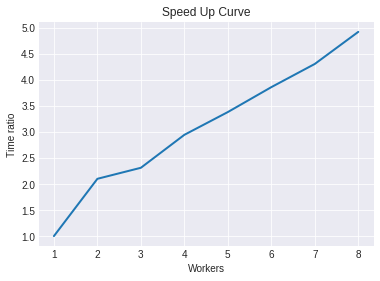

In [26]:
speed_up_curve(time_list, n_init)